In [56]:
import pandas as pd
df = pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\train.csv')

In [57]:
df = df[['시술 당시 나이',
        '총 시술 횟수',
        'IVF 임신 횟수',
        'IVF 출산 횟수',
        '남성 주 불임 원인',
        '남성 부 불임 원인',
        '여성 주 불임 원인',
        '여성 부 불임 원인',
        '부부 주 불임 원인',
        '부부 부 불임 원인',
        '불임 원인 - 난관 질환',
        '불임 원인 - 남성 요인',
        '불임 원인 - 배란 장애',
        '불임 원인 - 여성 요인',
        '불임 원인 - 자궁경부 문제',
        '불임 원인 - 자궁내막증',
        '불임 원인 - 정자 농도',
        '불임 원인 - 정자 운동성',
        '불임 원인 - 정자 형태',
        '불임 원인 - 정자 면역학적 요인',
        '난자 출처',
        '정자 출처',
        '해동 난자 수',
        '수집된 신선 난자 수',
        '파트너 정자와 혼합된 난자 수',
        '이식된 배아 수',
        '신선 배아 사용 여부',
        '동결 배아 사용 여부',
        '임신 성공 여부'
        ]]

In [60]:
age_map = {
    "만18-34세": 0,
    "만35-37세": 1,
    "만38-39세": 2,
    "만40-42세": 3,
    "만43-44세": 4,
    "만45-50세": 5
}

df['시술 당시 나이'] = df['시술 당시 나이'].map(age_map)

In [66]:
#한글빼기 
def removeHangual(tmp):
    return int(tmp[0])
df.loc[:,['총 시술 횟수']] = df['총 시술 횟수'].apply(removeHangual)
df.loc[:,['IVF 임신 횟수']] = df['IVF 임신 횟수'].apply(removeHangual)
df.loc[:,['IVF 출산 횟수']] = df['IVF 출산 횟수'].apply(removeHangual)

In [70]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['난자 출처'] = encoder.fit_transform(df['난자 출처'])
df['정자 출처'] = encoder.fit_transform(df['정자 출처'])

        시술 당시 나이 총 시술 횟수 IVF 임신 횟수 IVF 출산 횟수  남성 주 불임 원인  남성 부 불임 원인  \
0            0.0       0         0         0           0           0   
1            5.0       0         0         0           0           0   
2            0.0       1         0         0           0           0   
3            1.0       1         0         0           0           0   
4            0.0       0         0         0           0           0   
...          ...     ...       ...       ...         ...         ...   
256346       0.0       3         0         0           0           0   
256347       2.0       4         2         2           0           0   
256348       1.0       1         0         0           0           0   
256349       2.0       2         0         0           0           0   
256350       1.0       2         0         0           0           0   

        여성 주 불임 원인  여성 부 불임 원인  부부 주 불임 원인  부부 부 불임 원인  ...  \
0                0           0           0           0  ...   
1        

In [74]:
df = df.apply(lambda x: x.fillna(x.mean()), axis=0)

C:\Users\User\AppData\Local\Temp\ipykernel_10300\3866052108.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.apply(lambda x: x.fillna(x.mean()), axis=0)


# 학습 - 신경망 구성

In [84]:
target = df['임신 성공 여부']
df = df.drop(columns=['임신 성공 여부'],axis=1)

In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score
import numpy as np

def create_model():
    inputs = tf.keras.Input(shape=(28,))
    
    x = layers.Dense(28, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # AUC 메트릭 추가
    )
    
    return model

In [96]:
model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

BATCH_SIZE = 128
EPOCHS = 50

history = model.fit(
    df, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7411 - auc: 0.6604 - loss: 0.5297 - val_accuracy: 0.7418 - val_auc: 0.7085 - val_loss: 0.5010
Epoch 2/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7417 - auc: 0.7047 - loss: 0.5038 - val_accuracy: 0.7418 - val_auc: 0.7133 - val_loss: 0.5011
Epoch 3/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7406 - auc: 0.7048 - loss: 0.5040 - val_accuracy: 0.7418 - val_auc: 0.7095 - val_loss: 0.5038
Epoch 4/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7408 - auc: 0.7052 - loss: 0.5037 - val_accuracy: 0.7412 - val_auc: 0.7139 - val_loss: 0.5005
Epoch 5/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7429 - auc: 0.7077 - loss: 0.5008 - val_accuracy: 0.7418 - val_auc: 0.7047 - val_loss: 0.5008
Epoch 6/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7423 - auc: 0.7082 - loss: 0.5009 - val_accuracy: 0.7418 - val_auc: 0.7152 - val_loss: 0.4994
Epoch 7/50
1603/1603 ━━━━━━

8011/8011 ━━━━━━━━━━━━━━━━━━━━ 7s 880us/step
ROC-AUC Score: 0.7141


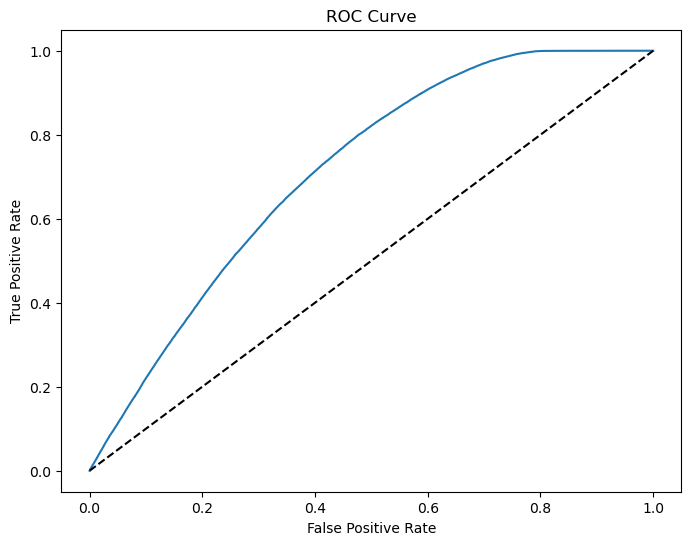

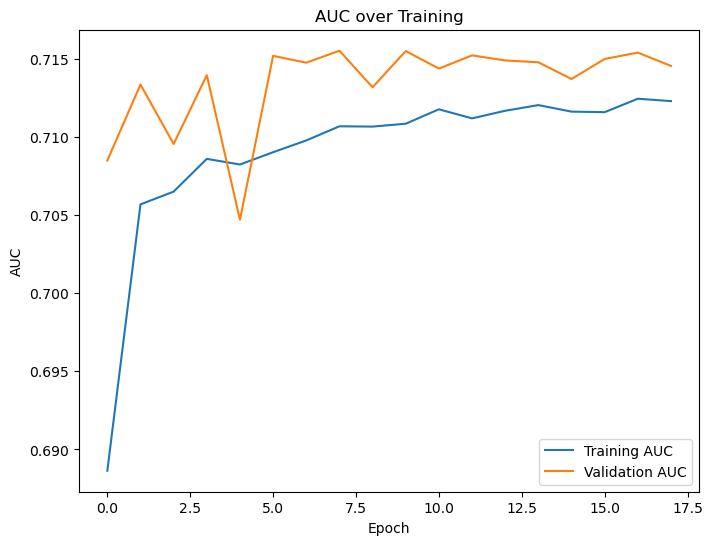

In [104]:
y_pred = model.predict(df)

roc_auc = roc_auc_score(target, y_pred)
print(f'ROC-AUC Score: {roc_auc:.4f}')

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(target, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Training')
plt.legend()
plt.show()

# 학습 - 의사결정트리

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X = df 
y = target  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.7087
ROC-AUC: 0.6339


# 학습 - 서동주팀원님 전처리 기반

In [ ]:
#단순한게 오히려 roc-auc가 높게 나오는 경우가 많아 해당 기본전처리를 바탕으로 신경망을 돌려봤습니다.
#입력 차원을 57개로 수정하여 돌렸습니다.

In [110]:
df = pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\other.csv',encoding='utf-8-sig')

In [114]:
target = df['임신 성공 여부']
df = df.drop(['임신 성공 여부'],axis=1)

In [118]:
def create_model():
    inputs = tf.keras.Input(shape=(57,))
    
    # 첫 번째 Dense 레이어도 57 유닛으로 수정
    x = layers.Dense(57, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [120]:
model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

BATCH_SIZE = 128
EPOCHS = 50

history = model.fit(
    df, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7404 - auc: 0.6846 - loss: 0.5207 - val_accuracy: 0.7460 - val_auc: 0.7399 - val_loss: 0.4841
Epoch 2/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7445 - auc: 0.7354 - loss: 0.4883 - val_accuracy: 0.7451 - val_auc: 0.7408 - val_loss: 0.4834
Epoch 3/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7443 - auc: 0.7340 - loss: 0.4885 - val_accuracy: 0.7466 - val_auc: 0.7434 - val_loss: 0.4832
Epoch 4/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7456 - auc: 0.7381 - loss: 0.4856 - val_accuracy: 0.7467 - val_auc: 0.7440 - val_loss: 0.4848
Epoch 5/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7451 - auc: 0.7418 - loss: 0.4847 - val_accuracy: 0.7486 - val_auc: 0.7443 - val_loss: 0.4813
Epoch 6/50
1603/1603 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7441 - auc: 0.7425 - loss: 0.4835 - val_accuracy: 0.7455 - val_auc: 0.7444 - val_loss: 0.4812
Epoch 7/50
1603/1603 ━━━━━━

8011/8011 ━━━━━━━━━━━━━━━━━━━━ 7s 886us/step
ROC-AUC Score: 0.7479


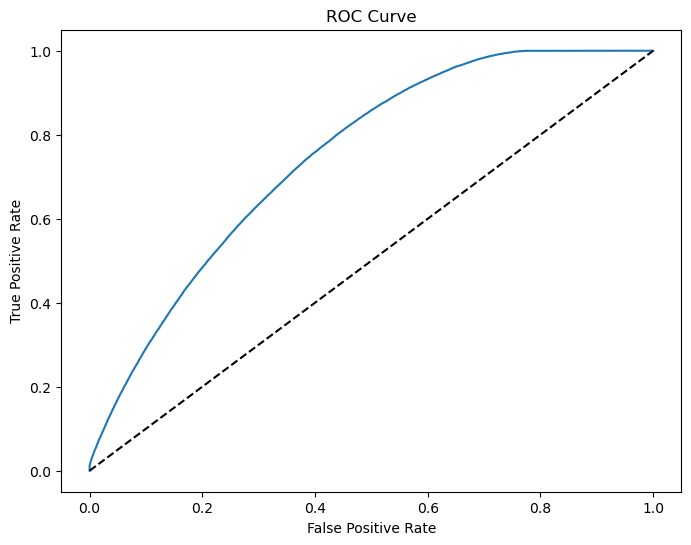

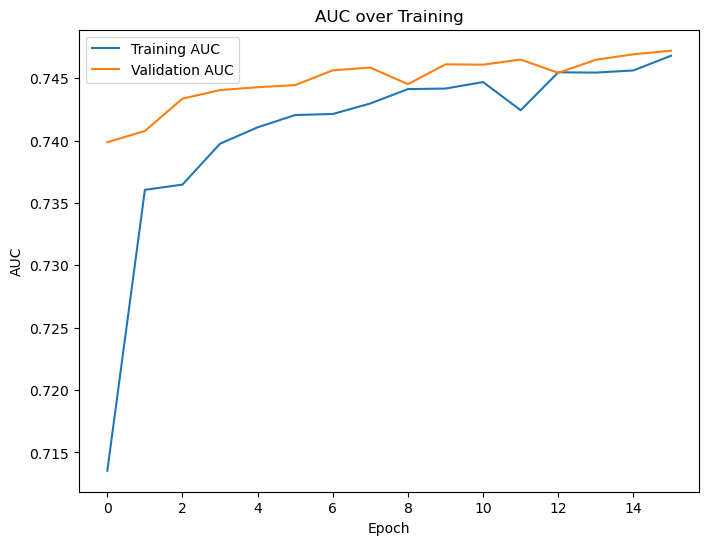

In [124]:
y_pred = model.predict(df)

roc_auc = roc_auc_score(target, y_pred)
print(f'ROC-AUC Score: {roc_auc:.4f}')

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(target, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Training')
plt.legend()
plt.show()

In [128]:
test = pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\other_test.csv',encoding='utf-8-sig')

In [130]:
y_pred = model.predict(test)

2815/2815 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step


In [132]:
y_pred

array([[9.5960866e-17],
       [3.5622192e-19],
       [1.7492072e-01],
       ...,
       [4.9042344e-01],
       [4.1043925e-01],
       [4.1302534e-15]], dtype=float32)

In [134]:
#시그모이드 활성화 함수 기준이므로 이진분류 
y_pred_binary = (y_pred>= 0.5).astype(int)

In [140]:
y_pred_binary = pd.DataFrame(y_pred_binary)

In [142]:
y_pred_binary.to_csv('prediction_DL.csv',encoding='utf-8-sig')

# 1차 성능 개선

In [ ]:
#1. 클래스 불균형 처리
#2. 과적합 방지
#3. 배치 정규화
#4. 활성화 함수
#5. 모델 복잡도 조정
#6. 정확도(Accuracy) 외의 지표 사용
#7. 학습률(Learning Rate) 조정

In [145]:
df = pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\other.csv',encoding='utf-8-sig')

In [146]:
target = df['임신 성공 여부']
df = df.drop(['임신 성공 여부'],axis=1)

In [151]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers

def create_model():
    inputs = tf.keras.Input(shape=(57,))
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [161]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])

class_weights = compute_class_weight('balanced', classes=classes, y=target)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

model.fit(df, target, epochs=20, batch_size=32, class_weight=class_weight_dict)


Epoch 1/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6240 - auc: 0.7439 - loss: 0.5671
Epoch 2/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6250 - auc: 0.7425 - loss: 0.5675
Epoch 3/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6332 - auc: 0.7439 - loss: 0.5670
Epoch 4/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6179 - auc: 0.7440 - loss: 0.5643
Epoch 5/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6271 - auc: 0.7445 - loss: 0.5678
Epoch 6/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6230 - auc: 0.7456 - loss: 0.5651
Epoch 7/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6204 - auc: 0.7454 - loss: 0.5658
Epoch 8/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6191 - auc: 0.7433 - loss: 0.5703
Epoch 9/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6203 - auc: 0.7449 - loss: 0.5651
Epoch 10/20
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.616

In [163]:
y_pred_prob = model.predict(df)  # 모델이 예측한 확률값 (1차원 배열로 반환됨)

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(target, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")


8011/8011 ━━━━━━━━━━━━━━━━━━━━ 7s 874us/step
ROC-AUC: 0.7501


In [165]:
test = pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\other_test.csv',encoding='utf-8-sig')

In [167]:
y_pred_prob = model.predict(test)

2815/2815 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step


In [173]:
y_pred_binary = (y_pred_prob>= 0.5).astype(int)

In [175]:
prediction = pd.DataFrame(y_pred_binary)
prediction.to_csv('prediction_DL.csv',encoding='utf-8-sig')

# 2차 성능 개선

In [ ]:
#1. SMOTE 적용
#2. 특성 엔지니어링
#3. 정규화 추가 개선
#4. ELU 형태로 변경
#5. Hyperparameter Tuning

In [179]:
df =  pd.read_csv(r'C:\Users\User\LG_Aimers\MainTask\other.csv',encoding='utf-8-sig')

In [181]:
target = df['임신 성공 여부']
df = df.drop(columns=['임신 성공 여부'],axis=1)

In [185]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df,target)

In [191]:
from tensorflow.keras import regularizers

def create_model():
    inputs = tf.keras.Input(shape=(57,))
    
    x = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


In [195]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

model = create_model()

classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

history = model.fit(
    X_resampled, y_resampled,
    epochs=20, 
    batch_size=32,  
    validation_split=0.2,   
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]  
)

test_loss, test_acc, test_auc = model.evaluate(X_resampled, y_resampled)
print(f"Test Accuracy: {test_acc}, Test AUC: {test_auc}")


Epoch 1/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6227 - auc: 0.6250 - loss: 0.7218 - val_accuracy: 0.1493 - val_auc: 0.0000e+00 - val_loss: 0.8712
Epoch 2/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6265 - auc: 0.6473 - loss: 0.6655 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.8058
Epoch 3/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6275 - auc: 0.6528 - loss: 0.6617 - val_accuracy: 0.1901 - val_auc: 0.0000e+00 - val_loss: 0.7710
Epoch 4/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6293 - auc: 0.6531 - loss: 0.6580 - val_accuracy: 0.0039 - val_auc: 0.0000e+00 - val_loss: 1.0269
Epoch 5/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6286 - auc: 0.6542 - loss: 0.6584 - val_accuracy: 0.8711 - val_auc: 0.0000e+00 - val_loss: 0.6376
Epoch 6/20
2445/9507 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6264 - auc: 0.6535 - loss: 0.6587 

KeyboardInterrupt: 

In [197]:
#생각보다 너무 낮게나와 ReLu로 다시 수정
from tensorflow.keras import regularizers

def create_model():
    inputs = tf.keras.Input(shape=(57,))
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


In [199]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

model = create_model()

classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

history = model.fit(
    X_resampled, y_resampled,
    epochs=20, 
    batch_size=32,  
    validation_split=0.2,   
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]  
)

test_loss, test_acc, test_auc = model.evaluate(X_resampled, y_resampled)
print(f"Test Accuracy: {test_acc}, Test AUC: {test_auc}")


Epoch 1/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.6246 - auc: 0.6154 - loss: 0.6936 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9258
Epoch 2/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6240 - auc: 0.6306 - loss: 0.6386 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9281
Epoch 3/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6242 - auc: 0.6085 - loss: 0.6473 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.8728
Epoch 4/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6263 - auc: 0.5950 - loss: 0.6520 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.8399
Epoch 5/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6231 - auc: 0.5971 - loss: 0.6532 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9656
Epoch 6/20
9507/9507 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6222 - auc: 0.5996 - loss: 0.6532 - val_accuracy: 0.0000e+00 - val_auc: 0.00